# Business Analytics
## Optimizing with multiple objectives: portfolio analytics
(C) 2021

In [1]:
from IPython.display import HTML, display

def optional_material():
    '''
    When run in a cell, this function will color the cell blue to indicate
    the material is optional
    '''
    script =  "var cell = this.closest('.code_cell');"
    script += "var editor = cell.querySelector('.input_area');"
    script += "editor.style.background='#bde4f0';"
    script += "this.parentNode.removeChild(this)"
    
    display(HTML(f'<img src onerror="{script}">'))
    
optional_material()

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:900px !important; }</style>"))

# Building an Efficient Frontier

### Loading stock data

In [2]:
# Start and end date for data we're loading
start_date      = '2019-01-01'
end_date        = '2022-12-31'

# The interval; Yahoo finance and Pandas use different codes to
# mean 'start of the month'
interval_yahoo  = '1mo'
interval_pandas = 'MS'

# Tickers we want to use to create our efficient frontier
tickers         = ['AAPL', 'ABT', 'AMGN', 'AXP', 'CVX', 'DIS', 'GE',
                       'IBM', 'MSFT', 'PEP', 'SLB', 'VZ', 'WMT', 'XOM']

In [3]:
# Install the yahoo finance API
#!pip install yfinance

In [4]:
import yfinance as yf

stock_data = {}

# Load relevant dates for each of our tickers
for ticker in tickers:
    stock_data[ticker] = yf.download(ticker,
                                     start    = start_date,
                                     end      = end_date,
                                     interval = interval_yahoo)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
# Remove timezone info from the infex
for ticker in tickers:
    stock_data[ticker].index = stock_data[ticker].index.tz_localize(None)

In [6]:
import pandas as pd
import numpy as np

In [7]:
# Create an index that contains the first day of every month
# from the start date to the end date
full_index = pd.date_range(start=start_date,
                           end=end_date,
                           freq=interval_pandas)

# Create a DataFrame with that index
df_returns = pd.DataFrame(index=full_index)

In [8]:
# Go through each stock, find the returns, and add them to df_returns
for ticker in tickers:
    this_df = stock_data[ticker]
    
    # For some reason, Yahoo finance returns some dates that are not
    # at the start of the month, even if we ask for monthly frequency.
    # Remove these dates that are not in the index of df_returns
    this_df = this_df[this_df.index.isin(df_returns.index)]
    
    # Ensure that there are no missing values in the data
    assert this_df['Adj Close'].isna().sum() == 0, 'Some months missing in Yahoo data'
    
    # Ensure we have at least 10 months worth of data
    assert len(this_df) > 10, 'Some tickers have less than 10 months of data'
    
    # Calculate the return
    this_close = this_df['Adj Close']
    prev_close = this_df['Adj Close'].shift(1)
    ticker_return = (this_close - prev_close)/prev_close
    
    # Add this ticker to df_returns
    df_returns[ticker] = ticker_return

In [9]:
# Find mean returns, standard deviation of returns, and correlation
# between all stocks
means = df_returns.mean().to_numpy()
stds  = df_returns.std().to_numpy()
covs = df_returns.cov().to_numpy()

### Constructing the optimization problem

In [10]:
from scipy import optimize

In [11]:
def portfolio_var(w):
    '''
    This function accepts an array of portfolio weights, and returns
    the variance of the resulting portfolio
    '''
    
    return w.transpose() @ covs @ w

In [12]:
x0 = [1/len(tickers)]*len(tickers)

In [13]:
equality_constraint = optimize.LinearConstraint(A  = [[1]*len(tickers)],
                                                lb = 1,
                                                ub = 1)

# Let's begin by assuming the returns have to be >=0 (i.e., no
# constraint; we'll later modify this
inequality_constraint = optimize.LinearConstraint(A  = [means],
                                                  lb = 0,
                                                  ub = np.inf)

In [14]:
bounds = optimize.Bounds(lb=0, ub=np.inf)

In [15]:
# Solve the problem
r = optimize.minimize(fun         = portfolio_var,
                      x0          = x0,
                      constraints = [equality_constraint,
                                     inequality_constraint],
                      bounds      = bounds)

In [16]:
r.success

True

In [17]:
r.fun

0.001363944287973635

In [18]:
r.x

array([0.00000000e+00, 7.37433983e-02, 1.38443055e-17, 0.00000000e+00,
       0.00000000e+00, 6.32030898e-18, 1.04355344e-03, 1.04083409e-17,
       5.18747609e-02, 2.21353657e-01, 5.11451738e-18, 3.97049973e-01,
       2.54837771e-01, 9.68861691e-05])

In [19]:
pd.DataFrame(np.round(r.x*100,2), index=tickers)

,0
AAPL,0.00
ABT,7.37
AMGN,0.00
AXP,0.00
CVX,0.00
DIS,0.00
GE,0.10
IBM,0.00
MSFT,5.19
PEP,22.14


In [20]:
print(f'Minimum std: {round(np.sqrt(r.fun)*100,2)}%')

Minimum std: 3.69%


In [21]:
min_var_return = (r.x*means).sum()
print(f'Minimum std portfolio has return {round(min_var_return*100,2)}%')

Minimum std portfolio has return 0.7%


### Constructing the efficient frontier

In [22]:
# The maximum return is achieved when investing in a single
# stock - the one wtih the highest return
max_return = max(means)

In [23]:
# Construct a list of 30 returns from the smallest (obtained with
# min variance) to the largest (investing in a single stock)
mean_returns = np.linspace(min_var_return, max_return, num=30)

In [24]:
# Create variables to store the lowest achievable variance for
# every return, and the associated portfolios
best_var_return = []
portfolios = {}

In [25]:
from tqdm import tqdm

# Go through each value of mean return
for r in tqdm(mean_returns):
    # Solve an optimization that minimizes variance, and insists on
    # a minimum return of at least r    
    opt_prob = optimize.minimize(fun = portfolio_var,
                                 x0  = x0,
                                 constraints = [equality_constraint,
                                                optimize.LinearConstraint
                                                            (A=[means], lb=r, ub=np.inf)],
                                 bounds = bounds)
    
    # Ensure the optimization was successful
    assert opt_prob.success
    
    # Save the resulting variance, and the portfolio
    best_var_return.append(np.sqrt(opt_prob.fun)*100)
    portfolios[np.sqrt(opt_prob.fun)*100] = opt_prob.x

100%|██████████| 30/30 [00:00<00:00, 80.05it/s]


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

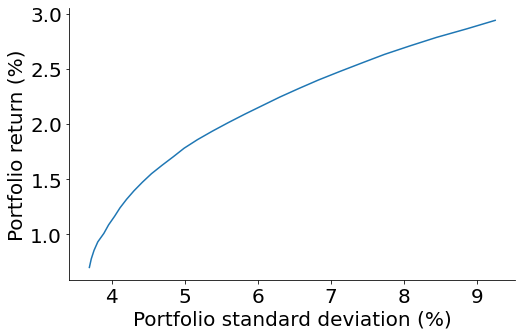

In [27]:
plt.figure(figsize=(8, 5))

plt.plot(best_var_return, mean_returns*100)

plt.xlabel('Portfolio standard deviation (%)', fontsize=20)
plt.ylabel('Portfolio return (%)', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

sns.despine()

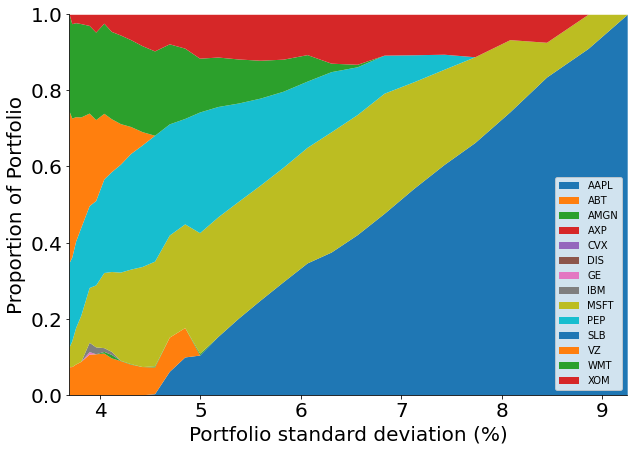

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

pd.DataFrame(portfolios, index=tickers).transpose().plot.area(linewidth=0, ax=ax)

plt.xlabel('Portfolio standard deviation (%)', fontsize=20)
plt.ylabel('Proportion of Portfolio', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

ax.margins(x=0, y=0)

plt.ylim([0,1])

sns.despine()

# GammaSoft Revisited

In [29]:
df_leads = pd.read_excel('/Users/gujiajun/Downloads/GammaSoft data (1).xlsx', sheet_name='Leads').set_index('LeadID')
df_reps = pd.read_excel('/Users/gujiajun/Downloads/GammaSoft data (1).xlsx', sheet_name='Reps').set_index('RepID')
df_interactions = pd.read_excel('/Users/gujiajun/Downloads/GammaSoft data (1).xlsx',
                                  sheet_name='Past interactions',
                                  skiprows=1).set_index('RepID')
df_distances = pd.read_excel('/Users/gujiajun/Downloads/GammaSoft data (1).xlsx', sheet_name='Distances', skiprows=1).set_index('RepID')

In [30]:
# Logistic regression coefficients
const    = -3.07
ext      = -0.18
past_use = 0.05
ser      = 0.42
f2f      = 0.17

# Calculate the revenues
revenues = np.zeros((len(df_reps), len(df_leads)))

for rep in df_reps.index:
    for lead in df_leads.index:
        w = ( const + ext*df_leads.loc[lead, 'EXT']
                         + past_use*df_leads.loc[lead, 'PAST_USE']
                         + ser*df_reps.loc[rep, 'SER']
                         + f2f*df_interactions.loc[rep, lead] )
        
        prob = 1/(1+np.exp(-w))
        
        revenues[rep,lead] = prob * df_leads.loc[lead, 'Size'] * 50

In [31]:
# First, solve the problem with no distance constraints
import pulp as pl

m = pl.LpProblem('XGen', pl.LpMaximize)
x = np.array([[pl.LpVariable(f'x_{i}_{j}', cat='Binary')
                       for j in df_leads.index] for i in df_reps.index])

for j in df_leads.index:
    m += (pl.lpSum(x[:, j]) <= 1, f'lead_{j}_constraint')
    
for i in df_reps.index:
    m += (pl.lpSum(x[i, :]) <= df_reps.loc[i, 'Capacity'], f'rep_{i}_constraint')

m += pl.lpSum(revenues*x)
pl.PULP_CBC_CMD().solve(m)

# Find the maximum disance needed (for maximum revenue)
max_distance = (np.array([[i.value() for i in j] for j in x]) * df_distances.to_numpy()).sum()
max_distance

322.39

In [32]:
# Add a distance constraint to the LP; start with the largest distance
m += pl.lpSum(df_distances.to_numpy()*x) <= max_distance, 'distance_constraint'

In [33]:
# Build the efficient frontier

distances = np.linspace(0, max_distance, num=30)
opt_revenue = []

for d in tqdm(distances):
    m.constraints['distance_constraint'] = (pl.lpSum(df_distances.to_numpy()*x) <= d)
    pl.PULP_CBC_CMD().solve(m)
    opt_revenue.append(m.objective.value())

100%|██████████| 30/30 [00:01<00:00, 17.01it/s]


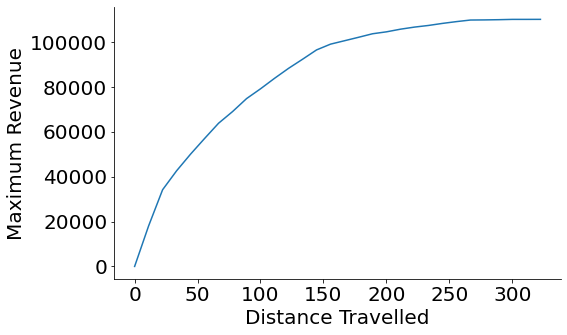

In [34]:
plt.figure(figsize=(8, 5))

plt.plot(distances, opt_revenue)

plt.xlabel('Distance Travelled', fontsize=20)
plt.ylabel('Maximum Revenue', fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

sns.despine()

# Side note: visualizing distances

In [35]:
def unpack_dv(dv):
    X_rep  = dv[:len(df_reps)]
    Y_rep  = dv[len(df_reps):(2*len(df_reps))]
    X_lead = dv[(2*len(df_reps)):(2*len(df_reps) + len(df_leads))]
    Y_lead = dv[(2*len(df_reps) + len(df_leads)):(2*len(df_reps) + 2*len(df_leads))]
    
    return (X_rep, Y_rep, X_lead, Y_lead)

In [36]:
def obj(dv):
    X_rep, Y_rep, X_lead, Y_lead = unpack_dv(dv)
    
    obj = 0
    
    for lead in df_leads.index:
        for rep in df_reps.index:
            true_dist_squared = df_distances.loc[rep, lead]**2
            var_dist_squared = (X_rep[rep] - X_lead[lead])**2 + (Y_rep[rep] - Y_lead[lead])**2
            
            obj += (true_dist_squared - var_dist_squared)**2
    
    return obj

In [37]:
np.random.seed(123)
opt_prob = optimize.minimize(fun = obj,
                             x0  = np.random.uniform(low=0, high=50, size=50))
opt_prob.fun

1.2471266127827574

In [38]:
# Extract and plot the final locations
X_rep, Y_rep, X_lead, Y_lead = unpack_dv(opt_prob.x)

([], <a list of 0 Text major ticklabel objects>)

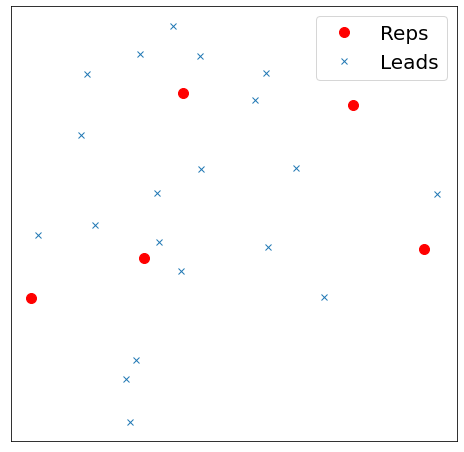

In [39]:
plt.figure(figsize=(8, 8))

plt.plot(X_rep, Y_rep, linewidth=0, marker='o', color='red', markersize=10, label='Reps')
plt.plot(X_lead, Y_lead, linewidth=0, marker='x', label='Leads')

plt.legend(fontsize=20)

plt.xticks([])
plt.yticks([])